In [ ]:
import os
import sys
import itertools

input_folder = 'API_responses'
output_folder = 'extracted_response'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']
for tell, prompt, length, order, sample_num in itertools.product(tells, prompts, lengths, orders, range(1, 21)):
    input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                            f'order_{order}.txt')
    output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                f'order_{order}.txt')
    with open(input_fn, 'r') as file:
        lines = file.readlines()
        answer_line = lines[0]
        answers = answer_line.split()
        if 'Answer:' in answers:
            answers.remove('Answer:')
        extracted = ' '.join(answers)
    if not os.path.exists(os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}')):
        os.makedirs(os.path.join(output_folder, tell, prompt,
                    f'length_{length}', f'sample_{sample_num}'))
    with open(output_fn, 'w') as file:
        file.writelines(extracted)

In [64]:
"""Process GPT-4 data"""
import os
import sys
import copy
import itertools
import numpy as np
import pprint

input_folder = 'extracted_response'
answer_folder = 'data_ToMh_old'
response_folder = 'API_responses'
output_folder = 'check_GPT-4'
summary_file = 'GPT-4_data.txt'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']
CoT_count, CoT_correct = [0, 0]
MC_count, MC_correct = [0, 0]
summary_lines = []
accuracy_data = {'Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))},
                'No_Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))}}
correctness_for_each = {'Tell': {'CoT': np.zeros((3, 5, 20)), 'MC': np.zeros((3, 5, 20))},
                'No_Tell': {'CoT': np.zeros((3, 5, 20)), 'MC': np.zeros((3, 5, 20))}}
cnt_vs_deception = np.zeros((5, 3))
correct_vs_deception = np.zeros((5, 3))

for tell, prompt, length, order in itertools.product(tells, prompts, lengths, orders):
    out_folder = os.path.join(output_folder, tell, prompt, f'length_{length}', f'order_{order}')
    summary_lines.append(f'{tell}, {prompt}, {length} chapters, {order} order: ')
    
    total_count = 0
    correct_count = 0

    for sample_num in range(1, 21):
        total_count += 1
        input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                f'order_{order}.txt')
        response_fn = os.path.join(response_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                f'order_{order}.txt')
        answer_fn = os.path.join(answer_folder, tell, 'CoT', f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
        output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')

        with open(answer_fn, 'r') as file:
            output_lines = file.readlines()
        count_deception = 0
        with open(answer_fn, 'r') as file:
            lines = file.readlines()
            for line in lines:
                if 'Answer:' in line.split(' '):
                    correct_answer = line.split(' ', 1)[1].split('\n')[0]
                    output_lines.append('Correct answer: ' + correct_answer + '\n')
                if 'privately' in line.split(' ') or 'publicly' in line.split(' '):
                    count_deception += 1
        cnt_vs_deception[order][count_deception // 2] += 1
        
        with open(input_fn, 'r') as file:
            lines = file.readlines()
            if len(lines[0].split(' ')) == 2:
                answer_line = lines[0].split(' ')[1]
                output_lines.append('GPT-4 Answer: ' + answer_line + '\n')
            else:
                # print(f"Eliminated: {tell}, {prompt}, {length} chapters, {order} order, " , lines)
                continue
        with open(response_fn, 'r') as file:
            lines = file.readlines()
            output_lines.append('GPT-4 Explain: ')
            output_lines += lines
                    
        if answer_line == correct_answer:
            correct_count += 1
            correct_vs_deception[order][count_deception // 2] += 1
        
        if not os.path.exists(os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}')):
            os.makedirs(os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}'))
        with open(output_fn, 'w') as file:
            file.writelines(output_lines)
    accuracy = correct_count / total_count
    summary_lines.append(str(accuracy) + '\n')
    accuracy_data[tell][prompt][length - 1][order] = accuracy
    with open(summary_file, 'w') as file:
        file.writelines(summary_lines)
pprint.pprint(accuracy_data)
pprint.pprint(cnt_vs_deception)
pprint.pprint(correct_vs_deception)

{'No_Tell': {'CoT': array([[1.  , 0.55, 0.6 , 0.6 , 0.55],
       [0.95, 0.7 , 0.5 , 0.25, 0.25],
       [0.95, 0.55, 0.3 , 0.4 , 0.45]]),
             'MC': array([[1.  , 0.7 , 0.75, 0.7 , 0.65],
       [0.95, 0.8 , 0.45, 0.15, 0.25],
       [0.7 , 0.55, 0.35, 0.4 , 0.4 ]])},
 'Tell': {'CoT': array([[0.75, 0.65, 0.5 , 0.5 , 0.3 ],
       [1.  , 0.55, 0.45, 0.5 , 0.5 ],
       [1.  , 0.45, 0.45, 0.3 , 0.15]]),
          'MC': array([[1.  , 0.6 , 0.4 , 0.4 , 0.45],
       [1.  , 0.6 , 0.6 , 0.45, 0.55],
       [0.95, 0.45, 0.4 , 0.3 , 0.2 ]])}}
array([[120.,  80.,  40.],
       [120.,  80.,  40.],
       [120.,  80.,  40.],
       [120.,  80.,  40.],
       [120.,  80.,  40.]])
array([[111.,  75.,  39.],
       [ 77.,  48.,  18.],
       [ 59.,  39.,  17.],
       [ 50.,  37.,  12.],
       [ 51.,  36.,   7.]])


In [ ]:
"""Plot heatmap for GPT-4"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

accuracy_data['Tell']['CoT'][0][0] = 1.0
accuracy_data['Tell']['CoT'][2][0] = 0.75

for tell, prompt in itertools.product(tells, prompts):
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(accuracy_data[tell][prompt], cmap=mpl.colormaps['Blues'])

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5), rotation=45)
    ax.set_yticks(np.arange(3), labels=[1, 2, 3])
    ax.set_xlabel('ToM order')
    ax.set_ylabel('Story length')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Accuracy", rotation=-90, va="bottom")
    communication = 'Exist deception' if tell == 'Tell' else 'No deception'
    ax.set_title(f'{communication}, {prompt} prompting')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(3):
        for j in range(5):
            fontcolor = 'black' if accuracy_data[tell][prompt][i][j] < 0.8 else 'white'
            text = ax.text(j, i, accuracy_data[tell][prompt][i][j],
                        ha="center", va="center", color=fontcolor)

    fig.tight_layout()
    plt.savefig(f'data_figs/{tell}_{prompt}.pdf')
    plt.show()

In [140]:
"""Count joint accuracy."""
import os
import sys
import copy
import itertools
import numpy as np
import pprint

input_folder = 'extracted_response'
answer_folder = 'data_ToMh_old'
response_folder = 'API_responses'
output_folder = 'check_GPT-4'
summary_file = 'GPT-4_data.txt'
lengths = [1, 2, 3]
orders = [0, 1, 2, 3, 4]
prompts = ['CoT', 'MC']
tells = ['No_Tell', 'Tell']
CoT_count, CoT_correct = [0, 0]
MC_count, MC_correct = [0, 0]
summary_lines = []
joint_accuracy_data = {'Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))},
                'No_Tell': {'CoT': np.zeros((3, 5)), 'MC': np.zeros((3, 5))}}
joint_cnt_vs_deception = np.zeros((5, 3))
joint_correct_vs_deception = np.zeros((5, 3))

for tell, prompt, length in itertools.product(tells, prompts, lengths):
    
    total_count = np.zeros(5)
    correct_count = np.zeros(5)

    for sample_num in range(1, 21):
        correct_so_far = True
        for i, order in enumerate(orders):
            total_count[i] += 1
            input_fn = os.path.join(input_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            response_fn = os.path.join(response_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                    f'order_{order}.txt')
            answer_fn = os.path.join(answer_folder, tell, 'CoT', f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            output_fn = os.path.join(output_folder, tell, prompt, f'length_{length}', f'sample_{sample_num}',
                                        f'order_{order}.txt')
            count_deception = 0
            with open(answer_fn, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    if 'Answer:' in line.split(' '):
                        correct_answer = line.split(' ', 1)[1].split('\n')[0]
                    if 'privately' in line.split(' ') or 'publicly' in line.split(' '):
                        count_deception += 1
            joint_cnt_vs_deception[order][count_deception // 2] += 1
            
            with open(input_fn, 'r') as file:
                lines = file.readlines()
                if len(lines[0].split(' ')) == 2:
                    answer_line = lines[0].split(' ')[1]
                else:
                    # print(f"Eliminated: {tell}, {prompt}, {length} chapters, {order} order, " , lines)
                    continue
                        
            if answer_line == correct_answer and correct_so_far:
                correct_count[i] += 1
                joint_correct_vs_deception[order][count_deception // 2] += 1
            elif answer_line != correct_answer:
                correct_so_far = False
    for order in orders:
        joint_accuracy_data[tell][prompt][length - 1][order] = correct_count[order] / total_count[order]

# pprint.pprint(joint_accuracy_data)
# pprint.pprint(joint_cnt_vs_deception)
# pprint.pprint(joint_correct_vs_deception)

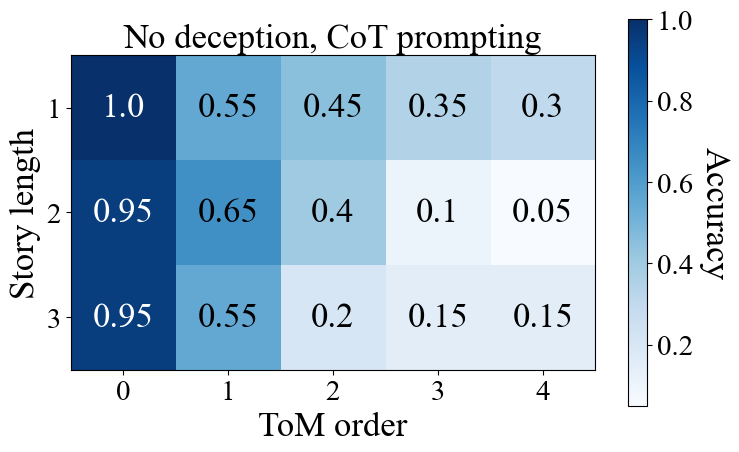

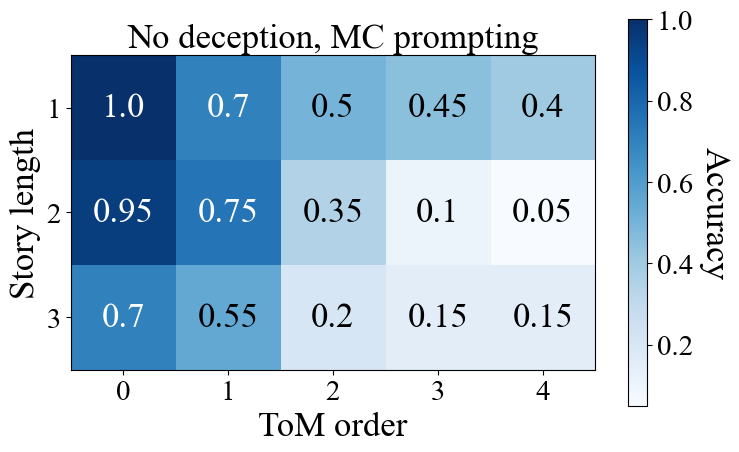

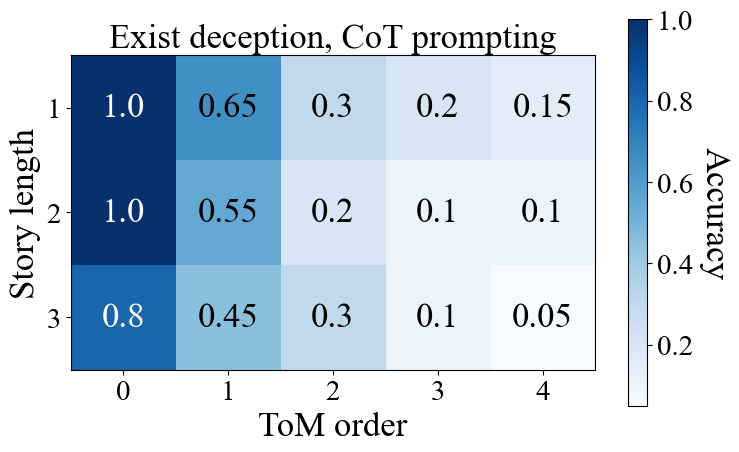

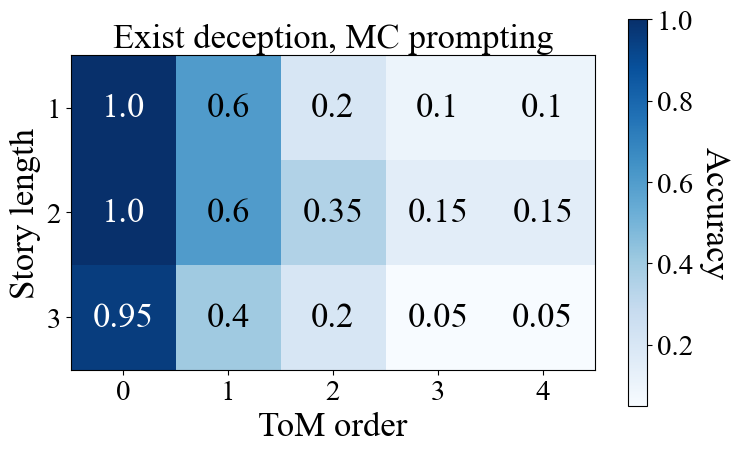

In [76]:
"""Plot joint accuracy heatmap for GPT-4"""
import numpy as np
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

joint_accuracy_data['Tell']['CoT'][0][0] = 1.0
joint_accuracy_data['Tell']['CoT'][2][0] = 0.8

for tell, prompt in itertools.product(tells, prompts):
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(joint_accuracy_data[tell][prompt], cmap=mpl.colormaps['Blues'])

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(5), rotation=45)
    ax.set_yticks(np.arange(3), labels=[1, 2, 3])
    ax.set_xlabel('ToM order')
    ax.set_ylabel('Story length')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Accuracy", rotation=-90, va="bottom")
    communication = 'Exist deception' if tell == 'Tell' else 'No deception'
    ax.set_title(f'{communication}, {prompt} prompting')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(),
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(3):
        for j in range(5):
            fontcolor = 'black' if joint_accuracy_data[tell][prompt][i][j] < 0.7 else 'white'
            text = ax.text(j, i, joint_accuracy_data[tell][prompt][i][j],
                        ha="center", va="center", color=fontcolor)

    fig.tight_layout()
    plt.savefig(f'data_figs/{tell}_{prompt}.pdf')
    plt.show()

In [ ]:
"""Accuracy vs. deception times"""
FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

markers = ['o', 's', '^', 'D', '.']
acc_vs_deception = np.zeros((5, 3))

for order in range(1, 5):
    for deception_num in range(3):
        acc_vs_deception[order][deception_num] = correct_vs_deception[order][deception_num] / cnt_vs_deception[order][deception_num]
print(acc_vs_deception)

colors = ['steelblue', 'orange', 'lightcoral']
plt.figure(figsize=(8, 5)) 
for i, acc in enumerate(acc_vs_deception):
    # plt.plot([0, 2, 4], acc, label=[0, 2, 4], marker=markers[i], color=colors[i], linewidth=2.6, markersize=10)
    if i == 0:
        continue
    plt.plot([0, 2, 4], acc, linewidth=2.6, marker=markers[i], markersize=9, label=f'Order {i}')

# 添加标题和轴标签
# plt.title('Multiple Line Plot')
ax = plt.gca()
plt.xlabel('Number of deception per story', labelpad=10)
plt.ylabel('Accuracy')
plt.ylim(0.1, 0.7)
plt.xticks([0, 2, 4])
plt.grid(axis='y', linestyle='dashed', which='both')
# plt.box(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('silver')
plt.tick_params(axis='x', which='both', bottom=False, pad=10)
plt.tick_params(left=False)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=3, frameon=False)
plt.subplots_adjust(bottom=0.2, top=0.9)

plt.savefig('linechart.pdf')
plt.show()

[[0.         0.         0.        ]
 [0.625      0.6        0.425     ]
 [0.35       0.2625     0.25      ]
 [0.21666667 0.1375     0.075     ]
 [0.18333333 0.125      0.05      ]]


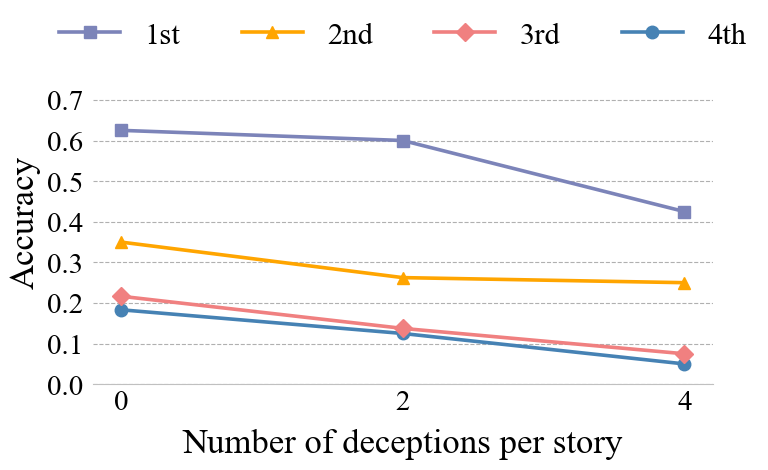

In [138]:
"""Joint accuracy vs. deception times"""
FONT_SIZE = 25
TICK_SIZE = 21
LEGEND_FONT_SIZE = 22

plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=FONT_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_FONT_SIZE)    # legend fontsize
plt.rc('figure', titlesize=42)  # fontsize of the figure title
# plt.rcParams["font.family"] = "Times New Roman"

markers = ['.', 's', '^', 'D', 'o']
joint_acc_vs_deception = np.zeros((5, 3))
order_label = ['0th', '1st', '2nd', '3rd', '4th']

for order in range(1, 5):
    for deception_num in range(3):
        joint_acc_vs_deception[order][deception_num] = joint_correct_vs_deception[order][deception_num] / joint_cnt_vs_deception[order][deception_num]
print(joint_acc_vs_deception)

joint_acc_vs_deception = np.array[[0,0,0], [0.625,0.6,0.425], [0.35,0.2625,0.25],[0.21666667,0.1375,0.075]
 [0.18333333 0.125      0.05      ]]

colors = ['neglect', '#7C84B9', 'orange', 'lightcoral', 'steelblue']
plt.figure(figsize=(8, 5)) 
for i, acc in enumerate(joint_acc_vs_deception):
    if i == 0:
        continue
    zorder = 3 if i == 3 else 2
    plt.plot([0, 2, 4], acc, linewidth=2.6, marker=markers[i], markersize=9, label=order_label[i], color=colors[i], zorder=zorder)

# 添加标题和轴标签
# plt.title('Multiple Line Plot')
ax = plt.gca()
plt.xlabel('Number of deceptions per story', labelpad=10)
plt.ylabel('Accuracy')
plt.ylim(0, 0.8)
plt.xticks([0, 2, 4])
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])
plt.grid(axis='y', linestyle='dashed', which='both')
# plt.box(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color('silver')
plt.tick_params(axis='x', which='both', bottom=False, pad=0)
plt.tick_params(left=False)
# plt.yscale('log')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=4, frameon=False)
plt.subplots_adjust(bottom=0.2, top=0.85)

plt.savefig('jointacc_vs_deception.pdf')
plt.show()